# **Statistics Lab 52568 - Lab 7 Solution**

First, we read the 2021 Israeli election results, and extract the parties voting data

In [1]:
import numpy as np  # a module for working with numerical array 
import pandas as pd  # a module for working with data-frames
from matplotlib import pyplot as plt
import random
import statsmodels.api as sm
import io
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


First, we need to mount our local drive to the colab network

In [2]:
# Add a check if we run in google colab or locally in jupyter notebook
run_in_colab = False
if 'google.colab' in str(get_ipython()):
    run_in_colab = True
    print('Running on CoLab')
else:
    print('Running locally on Jupyter')

Running on CoLab


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Loading elections 2020 and 2021 data - ballot and cities:
if run_in_colab:
    from google.colab import files
    uploaded = files.upload()

Saving votes per ballot 2020.csv to votes per ballot 2020.csv
Saving votes per city 2021.csv to votes per city 2021.csv
Saving votes per ballot 2021.csv to votes per ballot 2021.csv
Saving votes per city 2020.csv to votes per city 2020.csv


In [5]:
# Read two elections data (by cities):
data_type = "ballot"  # city
parties_dict_2021 ={'אמת' : "עבודה", 'מרצ' : "מרצ",  'ג' : "יהדות התורה", 'עם'  : "רעם",  'ת'  : "תקוה חדשה", 'ודעם'  : "הרשימה המשותפת", 'ב'  : "ימינה"
     , 'ט'  : "הציונות הדתית",'ל'  : "ישראל ביתנו", 'מחל'  : "הליכוד",  'פה'  : "יש עתיד", 'כן'  : "כחול לבן", 'שס'  : "שס"}
    
parties_dict_2020 ={'אמת' : "עבודה גשר מרצ", 'ג' : "יהדות התורה", 'ודעם'  : "הרשימה המשותפת"
    , 'טב'  : "ימינה", 'נץ'  : "עוצמה יהודית", 'ל'  : "ישראל ביתנו", 'מחל'  : "הליכוד",  'פה'  : "כחול לבן", 'שס'  : "שס"}

if run_in_colab:
    if data_type == "city":
      df_2021_raw = pd.read_csv(io.BytesIO(uploaded['votes per city 2021.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
      df_2020_raw = pd.read_csv(io.BytesIO(uploaded['votes per city 2020.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
    else:
      df_2021_raw = pd.read_csv(io.BytesIO(uploaded['votes per ballot 2021.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
      df_2020_raw = pd.read_csv(io.BytesIO(uploaded['votes per ballot 2020.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')

else:  # read local file
    if data_type == "ballot":
        df_2021_raw = pd.read_csv(data_path + 'votes per ballot 2021.csv',  encoding = 'iso-8859-8', index_col='שם ישוב')
        df_2020_raw = pd.read_csv(data_path + 'votes per ballot 2020.csv',  encoding = 'iso-8859-8', index_col='שם ישוב')
    else:
        df_2021_raw = pd.read_csv(data_path + 'votes per city 2021.csv',  encoding = 'iso-8859-8', index_col='שם ישוב')
        df_2020_raw = pd.read_csv(data_path + 'votes per city 2020.csv',  encoding = 'iso-8859-8', index_col='שם ישוב')

if data_type == "ballot":
    # preprocessing of ballot
    # convert columns with the parties' names

    df_2021_raw.rename(columns=parties_dict_2021, inplace=True)
    df_2021_raw = df_2021_raw[df_2021_raw.columns[:-1]]
    df_2021 = df_2021_raw.drop('סמל ועדה', axis=1) # new column added in Sep 2019
    df_2021 = df_2021[df_2021.columns[9:]] # removing "metadata" columns

    df_2020_raw.rename(columns=parties_dict_2020, inplace=True)
    df_2020_raw = df_2020_raw[df_2020_raw.columns[:-1]]
    df_2020 = df_2020_raw.drop('סמל ועדה', axis=1) # new column added in Sep 2019
    df_2020 = df_2020[df_2020.columns[9:]] # removing "metadata" columns
else:
    # preprocessing of cities 
    df_2021_raw.rename(columns=parties_dict_2021, inplace=True)
    df_2021_raw = df_2021_raw[df_2021_raw.columns[:-1]]
    df_2021 = df_2021_raw.drop('סמל ועדה', axis=1) # new column added in Sep 2019
    df_2021 = df_2021[df_2021.columns[5:]] # removing "metadata" columns

    df_2020_raw.rename(columns=parties_dict_2020, inplace=True)
    df_2020_raw = df_2020_raw[df_2020_raw.columns[:-1]]
    df_2020 = df_2020_raw.drop('סמל ועדה', axis=1) # new column added in Sep 2019
    df_2020 = df_2020[df_2020.columns[5:]] # removing "metadata" columns
# Dataset is now stored in a Pandas Dataframe

We use only the parties which their voting **percentage** 
in a given city is above a % threshold, and we remove the results of 'Maatafot hitzoniot':

In [6]:
# Compute votes share only for parties above a certain threshold 
def parties_votes_percents(df, thresh):
    par = df.sum().div(df.sum().sum()).sort_values(ascending=False)
    return par[par > thresh]

total_votes = parties_votes_percents(df_2021, 0.035)  # total votes for each party
names = total_votes.keys() # largest parties

total_votes_2020 = parties_votes_percents(df_2020, 0.035)  # total votes for each party
names_2020 = total_votes_2020.keys().tolist() # largest parties
names_2020.append('עוצמה יהודית')

a. Adapting data so we will have only ballots that were in 2020 and in 2021:

In [7]:
df_2020_ballot = df_2020_raw.reset_index()
df_2021_ballot = df_2021_raw.reset_index()
ballot_match = df_2020_ballot.set_index(['קלפי', 'סמל ישוב','שם ישוב']).join(df_2021_ballot.set_index(['קלפי', 'סמל ישוב','שם ישוב']), lsuffix = '-2020' , how='inner')

ballot_2021 = ballot_match[ballot_match.columns[len(df_2020_ballot.columns)-3:]]
ballot_2020 = ballot_match[ballot_match.columns[0:len(df_2020_ballot.columns)-3]]
ballot_2020.columns = df_2020_ballot.set_index(['קלפי', 'סמל ישוב','שם ישוב']).columns
ballot_2020.head(5)

סמל ועדה  ברזל  ריכוז  שופט  ...  קי  קך  קץ  שס
קלפי סמל ישוב שם ישוב                                        ...                
3.0  472      אבו גוש                  2   738      2     0  ...   0   0   1   6
5.0  472      אבו גוש                  2   740      2     0  ...   0   0   0   2
8.0  472      אבו גוש                  2   743      2     0  ...   0   0   0   0
1.0  958      אבו עבדון שבט           18  9873      1     0  ...   0   0   0   0
     1342     אבו קרינאת יישוב        18  9878      2     0  ...   0   0   0   0

[5 rows x 38 columns]

In [8]:

#Now we will merge the parties that are togeter in 2020 but were seperated in 2021:
parties_2020 = ballot_2020.copy()

#splitting to עבודה and מרצ 
parties_2020['מרצ'] = 0.5 *parties_2020['עבודה גשר מרצ']
parties_2020['עבודה'] = 0.5 *parties_2020['עבודה גשר מרצ']
parties_2020.drop('עבודה גשר מרצ', axis=1)
#splitting to רעם and המשותפת
parties_2020['רעם'] = 0.4 *parties_2020['הרשימה המשותפת']
parties_2020['הרשימה המשותפת'] = 0.6 *parties_2020['הרשימה המשותפת']
#splitting to תקוה חדשה and הליכוד
parties_2020['תקוה חדשה'] = 0.167 *parties_2020['הליכוד']
parties_2020['הליכוד'] = 0.833 *parties_2020['הליכוד']
#splitting to כחול לבן and יש עתיד
parties_2020['יש עתיד'] = 0.667 *parties_2020['כחול לבן']
parties_2020['כחול לבן'] = 0.333 *parties_2020['כחול לבן']
#splitting to ימינה and הציונות הדתית
parties_2020['הציונות הדתית'] = 0.4*parties_2020['ימינה']
parties_2020['ימינה'] = 0.6 *parties_2020['ימינה']
parties_2020['הציונות הדתית'] = parties_2020['הציונות הדתית']  + parties_2020['עוצמה יהודית']
parties_2020.drop('עוצמה יהודית', axis = 1)

#only perties + normalization:
parties_2020 = parties_2020[parties_2020.columns[8:]]
parties_2020 = parties_2020.div(parties_2020.sum(axis = 1), axis = 0)
parties_2020.head(5)

עבודה גשר מרצ  ...  הציונות הדתית
קלפי סמל ישוב שם ישוב                          ...               
3.0  472      אבו גוש                0.008721  ...       0.004070
5.0  472      אבו גוש                0.039855  ...       0.005072
8.0  472      אבו גוש                0.019608  ...       0.001569
1.0  958      אבו עבדון שבט          0.000000  ...       0.000000
     1342     אבו קרינאת יישוב       0.026471  ...       0.001176

[5 rows x 36 columns]

In [10]:
#only perties + normalization:
parties_2021 = ballot_2021.copy()

parties_2021 = parties_2021[parties_2021.columns[8:]]
parties_2021 = parties_2021.div(parties_2021.sum(axis = 1), axis= 0)
parties_2021.head(5)

עבודה  ימינה  ...        שס  תקוה חדשה
קלפי סמל ישוב שם ישוב                            ...                     
3.0  472      אבו גוש           0.012605    0.0  ...  0.021008   0.000000
5.0  472      אבו גוש           0.015075    0.0  ...  0.000000   0.000000
8.0  472      אבו גוש           0.000000    0.0  ...  0.000000   0.000000
1.0  958      אבו עבדון שבט     0.000000    0.0  ...  0.000000   0.000000
     1342     אבו קרינאת יישוב  0.000000    0.0  ...  0.003984   0.007968

[5 rows x 39 columns]

### b) 
For each election, we find 10 ballots with the largest total squared difference between the avrage voting shares in the city and the ballots' voting share. We check only ballots in cities with less then 50000 bzb. 

The relevant cities:

In [11]:
small_cities = ballot_2021.groupby('שם ישוב').sum()
small_cities = small_cities.iloc[np.where(small_cities['בזב']<= 50000)]


In [12]:
print(small_cities)

                  סמל ועדה   ברזל  ריכוז  שופט  ...  רף  רק   שס  תקוה חדשה
שם ישוב                                         ...                        
אבו גוש                  6   2541      6     0  ...   0   0    5          0
אבו עבדון שבט           18  11361      1     0  ...   0   0    0          0
אבו קרינאת יישוב        18  11473      2     0  ...   0   0    1          2
אבו תלול                36  22949      2     0  ...   0   0    0          0
אבטין                   16   7987      2     0  ...   0   0    0         19
...                    ...    ...    ...   ...  ...  ..  ..  ...        ...
תפרח                    36  21609      2     0  ...   0   0  133          0
תקומה                   18  10739      1     0  ...   0   0    7         22
תראבין אצאנע שבט        18  11410      1     0  ...   0   0    0          0
תראבין אצאנעישוב        18  11360      1     0  ...   0   0    2          0
תרום                     2    956      1     0  ...   0   0   46         29

[972 rows x

Find the top 10 ballots for each election-

In [13]:
def diff_calc(df):
  mean_city = df.mean(axis=0)
  diff = df - mean_city
  return diff

# for 2020
parties_2020_small = parties_2020.iloc[np.where(parties_2020.index.get_level_values(2).isin(small_cities.index))]
top_10_2020 = ((parties_2020_small.groupby('שם ישוב').apply(lambda x: diff_calc(x)))**2).sum(axis=1).nlargest(10)
print(top_10_2020)

קלפי   סמל ישוב  שם ישוב    
60.0   1061      נוף הגליל      0.640518
40.0   8000      צפת            0.588992
57.0   6700      טבריה          0.582042
951.0  8500      רמלה           0.520959
50.0   8500      רמלה           0.519249
950.0  8500      רמלה           0.516820
28.0   1063      מעלותתרשיחא    0.516307
18.1   7000      לוד            0.481976
8.0    7000      לוד            0.480856
5.0    7000      לוד            0.477839
dtype: float64


In [14]:
# for 2021
parties_2021_small = parties_2021.iloc[np.where(parties_2021.index.get_level_values(2).isin(small_cities.index))]
top_10_2021 = ((parties_2021_small.groupby('שם ישוב').apply(lambda x: diff_calc(x)))**2).sum(axis=1).nlargest(10)
print(top_10_2021)

קלפי   סמל ישוב  שם ישוב    
60.0   1061      נוף הגליל      0.704431
28.0   1063      מעלותתרשיחא    0.584095
951.0  8500      רמלה           0.577244
57.0   6700      טבריה          0.569885
50.0   8500      רמלה           0.558536
950.0  8500      רמלה           0.485840
8.0    7000      לוד            0.474154
952.1  7000      לוד            0.450754
19.0   8000      צפת            0.436000
18.1   7000      לוד            0.435595
dtype: float64


Looks like we found many heterogenic cities with mixed Jews and Arabs population. The ballots are very similar between the two eelections

### c)
10 ballots with the largest total squared difference between their voting shares for the 13 big parties in the two elections


In [15]:
top_10_c = ((parties_2020[names]-parties_2021[names])**2).sum(axis=1).nlargest(10)
top_10_c

קלפי   סמל ישוב  שם ישוב         
1.0    1366      נווה                1.006268
12.0   1054      תל שבע              0.589479
623.0  3000      ירושלים             0.581476
1.0    1363      בני נצרים           0.579312
       1375      אבו תלול            0.577604
       1347      קצר אסר             0.577384
3.0    965       אטרש שבט            0.562058
1.0    1265      שומריה              0.554367
2.0    1375      אבו תלול            0.550187
1.0    1342      אבו קרינאת יישוב    0.545274
dtype: float64

### d)
10 ballots with the largest squared difference between the two elections only in the coalition parties:

In [16]:
rel_parties = ['רעם','יש עתיד','מרצ','עבודה','כחול לבן','ישראל ביתנו','תקוה חדשה','ימינה']
top_10_d = ((parties_2020[rel_parties]-parties_2021[rel_parties])**2).sum(axis=1).nlargest(10)
top_10_d

קלפי  סמל ישוב  שם ישוב         
1.0   1342      אבו קרינאת יישוב    0.363588
8.0   1192      ערערהבנגב           0.310108
1.0   1347      קצר אסר             0.297632
3.0   965       אטרש שבט            0.291623
2.0   965       אטרש שבט            0.287039
1.0   1375      אבו תלול            0.283740
12.0  1054      תל שבע              0.279264
1.0   1169      הוואשלה שבט         0.269897
      1360      סעוה                0.269426
15.0  1161      רהט                 0.251137
dtype: float64

### e)
10 ballots with the maximal avrage voting share (kosher/bzb)



In [17]:
ballot_2020_with_bzb = ballot_2020.iloc[np.where(ballot_2020['בזב']!=0)]
ballot_2021_with_bzb = ballot_2021.iloc[np.where(ballot_2021['בזב']!=0)]

ballot_2021_with_bzb['אחוז הצבעה'] = ballot_2021_with_bzb['כשרים']/ballot_2021_with_bzb['בזב']
ballot_2020_with_bzb['אחוז הצבעה'] = ballot_2020_with_bzb['כשרים']/ballot_2020_with_bzb['בזב']
turnout = (ballot_2021_with_bzb['אחוז הצבעה'] + ballot_2020_with_bzb['אחוז הצבעה'])/2 
top_10_e = turnout.nlargest(10) # drop inf and find largest
top_10_e

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


קלפי  סמל ישוב  שם ישוב 
1.0   440       יסודות      0.917590
      1365      אליאב       0.893607
      1065      זמרת        0.893331
      3822      רחלים       0.888997
      1371      גני טל      0.886892
      1369      נטע         0.881677
      3777      סנסנה       0.878813
11.0  922       רכסים       0.872759
20.2  3730      גבעת זאב    0.871287
5.0   922       רכסים       0.869820
Name: אחוז הצבעה, dtype: float64

### f)
10 ballots with the maximal avrage 'psulim' share (psulim/bzb)



In [18]:
ballot_2021_with_bzb['אחוז הפסולים'] = ballot_2021_with_bzb['פסולים']/ballot_2021_with_bzb['בזב']
ballot_2020_with_bzb['אחוז הפסולים'] = ballot_2020_with_bzb['פסולים']/ballot_2020_with_bzb['בזב']
psulim = (ballot_2021_with_bzb['אחוז הפסולים'] + ballot_2020_with_bzb['אחוז הפסולים'])/2 
top_10_f = psulim.nlargest(10) # drop inf and find largest
print(top_10_f)

קלפי   סמל ישוב  שם ישוב      
488.0  3000      ירושלים          0.025037
19.0   1061      נוף הגליל        0.023501
71.1   9000      באר שבע          0.023385
3.0    3797      מודיעין עילית    0.020285
134.0  6100      בני ברק          0.019583
575.0  3000      ירושלים          0.018637
576.0  3000      ירושלים          0.018354
59.0   1061      נוף הגליל        0.017667
38.0   2630      קרית גת          0.017641
1.0    102       מאיר שפיה        0.017624
Name: אחוז הפסולים, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### g) 
10 ballots with the largest distance in their average voting share between the two elections

In [19]:
diff_turnout = abs(ballot_2020_with_bzb['אחוז הצבעה'] - ballot_2021_with_bzb['אחוז הצבעה']) 
top_10_g = diff_turnout.nlargest(10) #  find largest
print(top_10_g)


קלפי   סמל ישוב  שם ישוב   
1.0    456       שורש          0.692827
515.0  8600      רמת גן        0.501075
13.0   1327      מעלה עירון    0.470725
32.1   2710      אום אלפחם     0.445376
2.0    386       בני דרור      0.444206
3.0    447       נורדיה        0.435557
223.0  7900      פתח תקווה     0.410096
32.0   2500      נשר           0.407473
211.0  6600      חולון         0.398370
15.0   1327      מעלה עירון    0.389452
Name: אחוז הצבעה, dtype: float64


### Plotting function:

In [40]:
def bar_plots(parties_2020, parties_2021, tops, names, seif_b = False, Y_2021 = False):
  fig, ax = plt.subplots(2, 5, figsize=(20,10))
  width = 0.3  # set column width 

  votes_2020 = parties_2020[names].loc[tops]  # total votes for each party
  if seif_b:
    wanted_cities = tops.get_level_values(2)
    votes_2021 = parties_2020.reset_index().set_index('שם ישוב').loc[wanted_cities[0]].groupby('שם ישוב').mean()[names] # normalize by number of ballots in city
#    if Y_2021:
#      ksherim = ballot_2021.reset_index().set_index('שם ישוב').loc[wanted_cities[0]].groupby('שם ישוב').sum()[['בזב','כשרים']]
#    else:
#      ksherim = ballot_2020.reset_index().set_index('שם ישוב').loc[wanted_cities[0]].groupby('שם ישוב').sum()[['בזב','כשרים']]

    for city in wanted_cities[1:]:
      votes_2021 = votes_2021.append(parties_2020.reset_index().set_index('שם ישוב').loc[city].groupby('שם ישוב').mean()[names] ) # need to normalize
#      if Y_2021:
#        ksherim = ksherim.append(ballot_2021.reset_index().set_index('שם ישוב').loc[city].groupby('שם ישוב').sum()[['בזב','כשרים']])
#      else:
#        ksherim = ksherim.append(ballot_2020.reset_index().set_index('שם ישוב').loc[city].groupby('שם ישוב').sum()[['בזב','כשרים']])
  else:
    votes_2021 = parties_2021[names].loc[tops]  # do not normalize 

  rev_names = [name[::-1] for name in list(names)]
  n = len(names) 

  for ballot in range(10):
    title_top = str(tops[ballot][0]) +" " + str(tops[ballot][1]) + " " +tops[ballot][2][::-1]
    bar_2020 = ax[ballot//5, ballot%5].bar(np.arange(n), list(votes_2020.iloc[ballot]), width, color='b')
    bar_2021 = ax[ballot//5, ballot%5].bar(np.arange(n)+width, list(votes_2021.iloc[ballot]), width, color='r')
    ax[ballot//5, ballot%5].set_title(title_top, fontsize=14)

    ax[ballot//5, ballot%5].set_xticks(np.arange(n))
    ax[ballot//5, ballot%5].set_xticklabels(rev_names, rotation=90)
#    if seif_b:
#      ax[ballot//5, ballot%5].legend((bar_2021[0], bar_2020[0]),
#                                   ('בושי: ' + 'םירשכ- '+ str(ksherim.iloc[ballot]['כשרים']) +
#                                     ', בזב- ' + str(ksherim.iloc[ballot]['בזב']), 
#                                    'יפלק: ' + 'םירשכ- '+ str(ballot_2020.loc[tops[ballot], 'כשרים']) +
#                                     ', בזב- ' + str(ballot_2020.loc[tops[ballot], 'בזב'])))
#    else:
#      ax[ballot//5, ballot%5].legend((bar_2021[0], bar_2020[0]),
#                                   ('2021: ' + 'םירשכ- '+ str(ballot_2021.loc[tops[ballot], 'כשרים']) +
#                                     ', בזב- ' + str(ballot_2021.loc[tops[ballot], 'בזב']), 
#                                    '2020: ' + 'םירשכ- '+ str(ballot_2020.loc[tops[ballot], 'כשרים']) +
#                                     ', בזב- ' + str(ballot_2020.loc[tops[ballot], 'בזב'])))
    
  for ax in ax.flat:
    ax.set_ylabel('Votes percent')
    ax.set_xlabel('Parties Names')
    
  plt.tight_layout()
  plt.show()



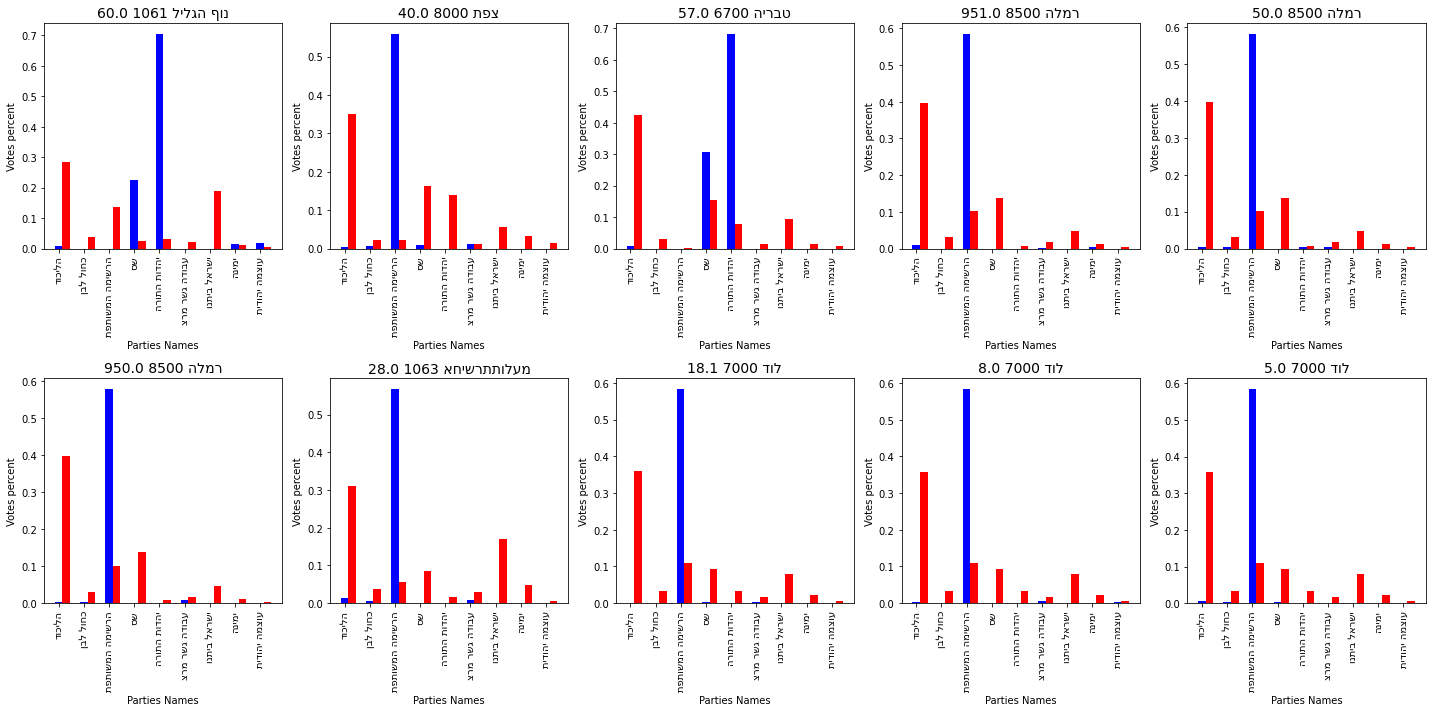

In [41]:
bar_plots(parties_2020, parties_2020, top_10_2020.index, names_2020, True, False)  # Show ballots found in (b) 

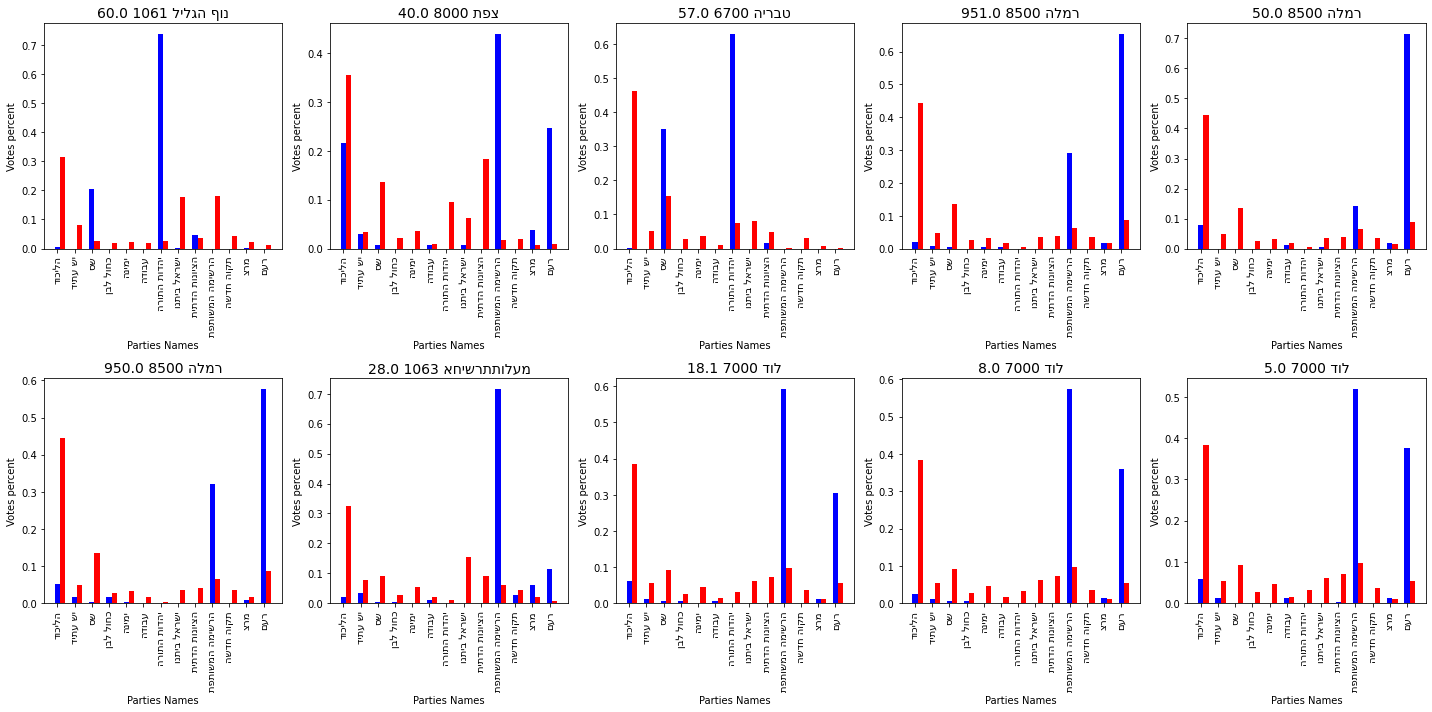

In [43]:
bar_plots(parties_2021, parties_2021, top_10_2020.index, names, True, True)

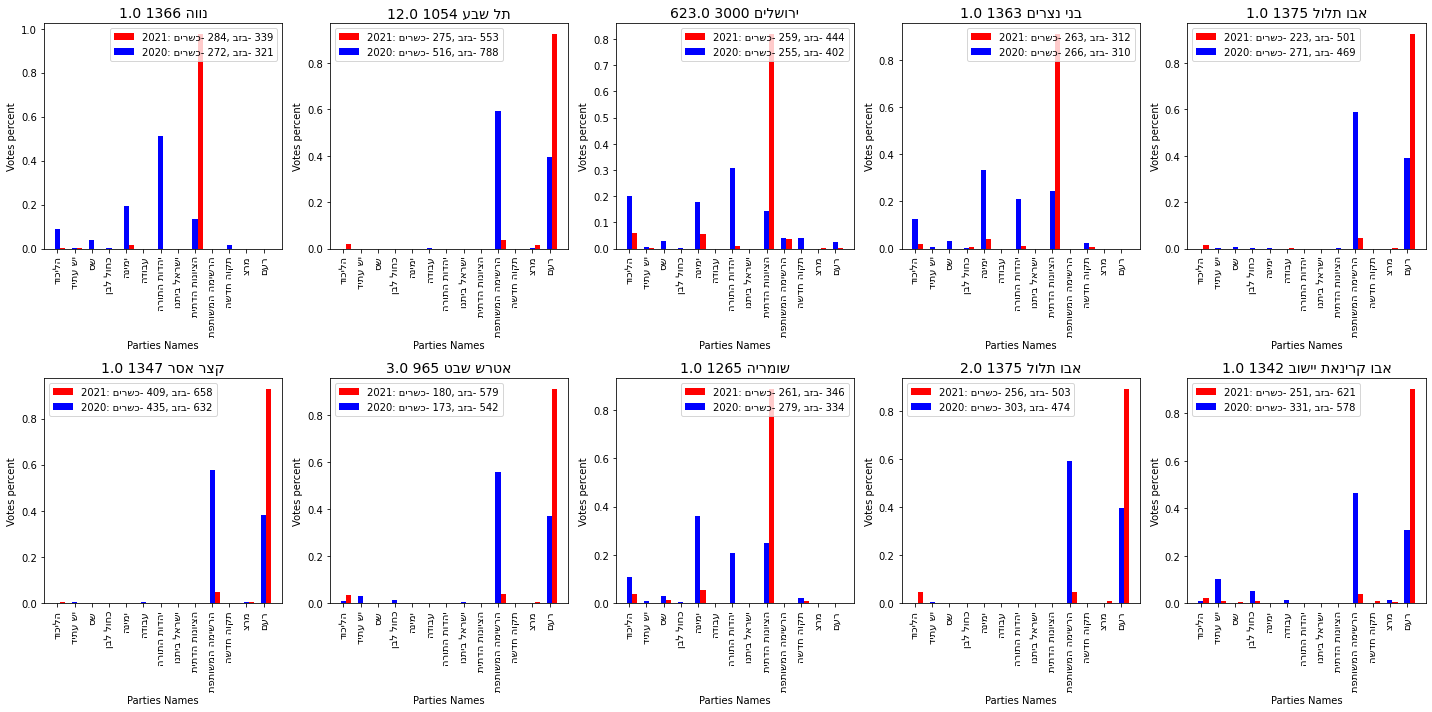

In [24]:
bar_plots(parties_2020, parties_2021, top_10_c.index, names)

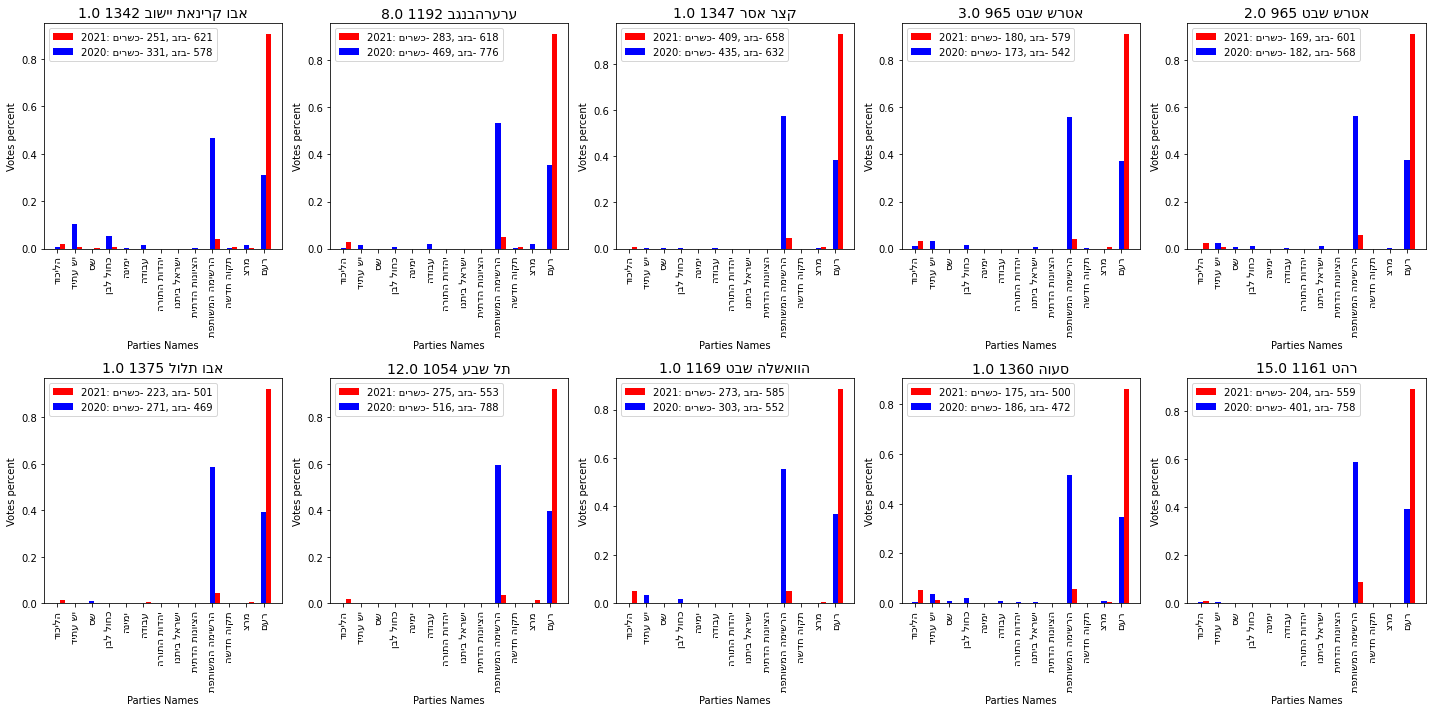

In [25]:
bar_plots(parties_2020, parties_2021, top_10_d.index, names)

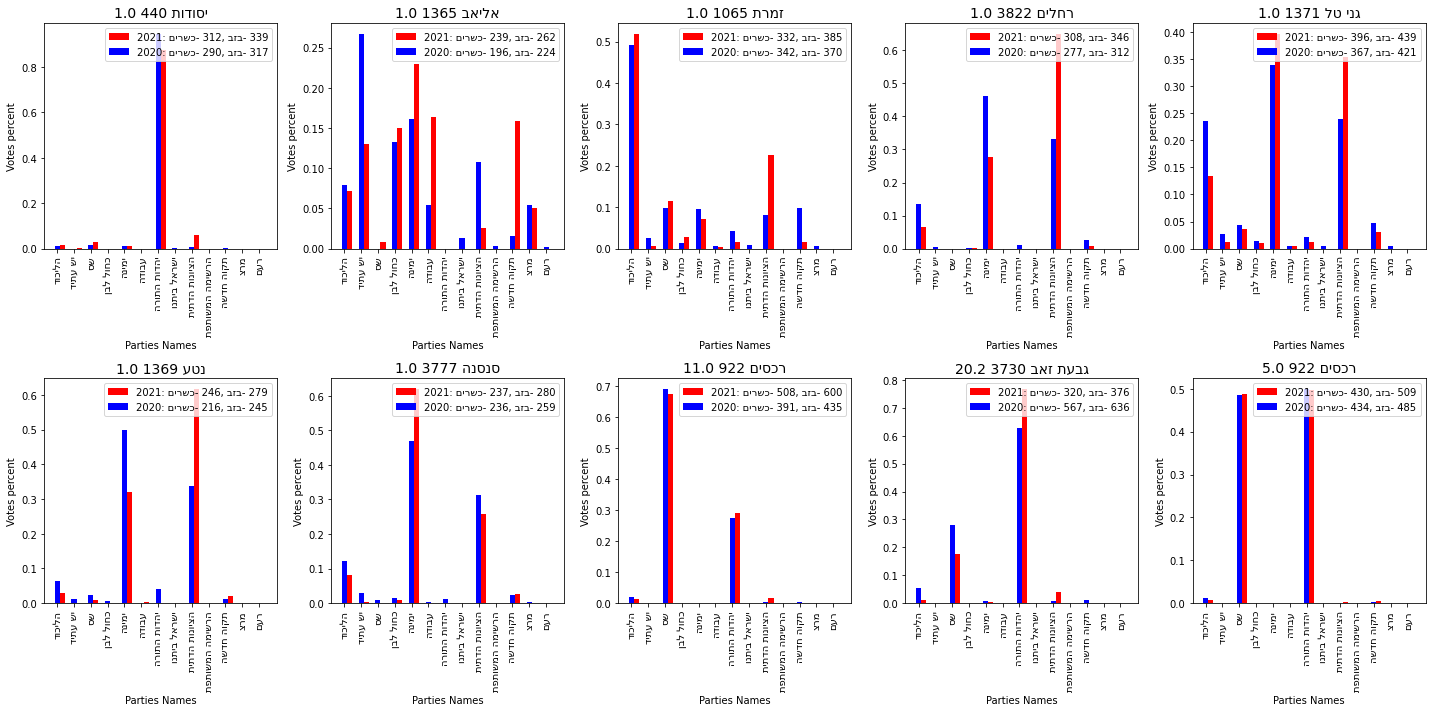

In [26]:
bar_plots(parties_2020, parties_2021, top_10_e.index, names)

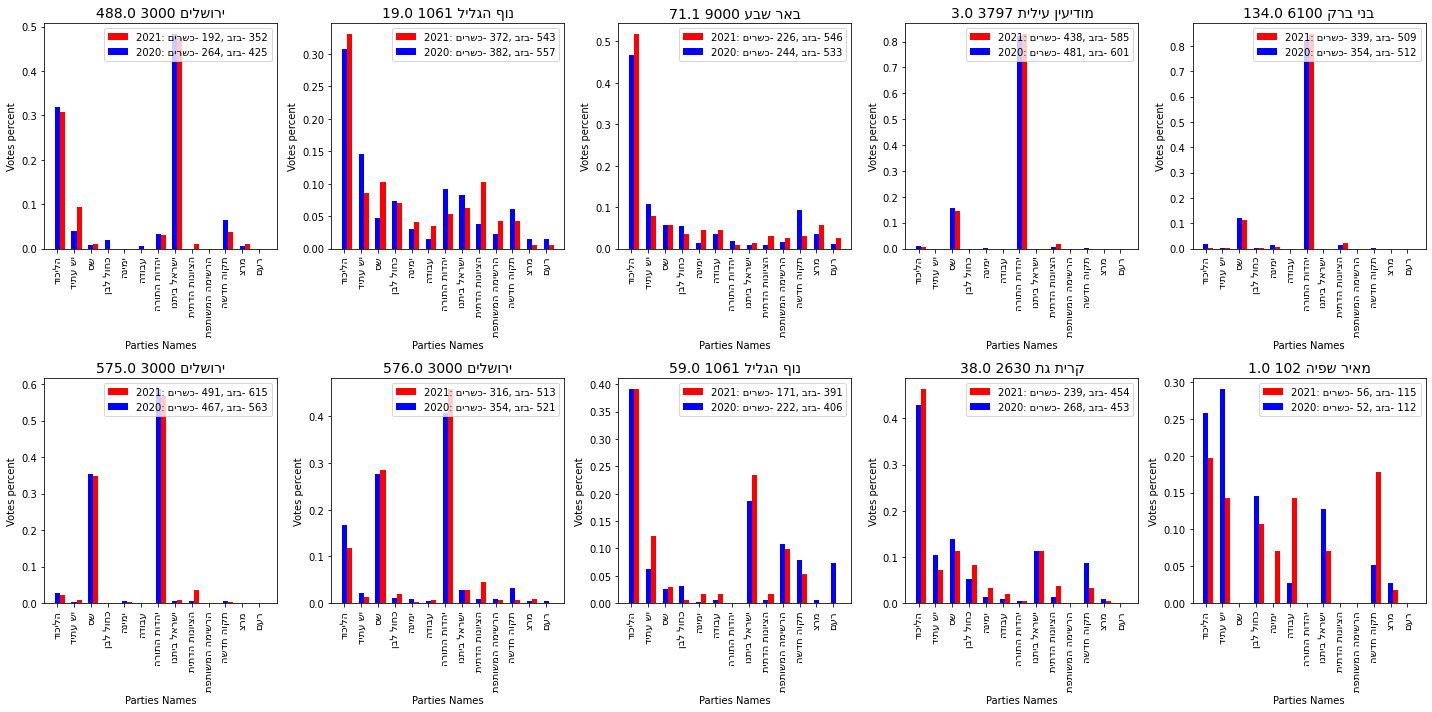

In [27]:
bar_plots(parties_2020, parties_2021, top_10_f.index, names)

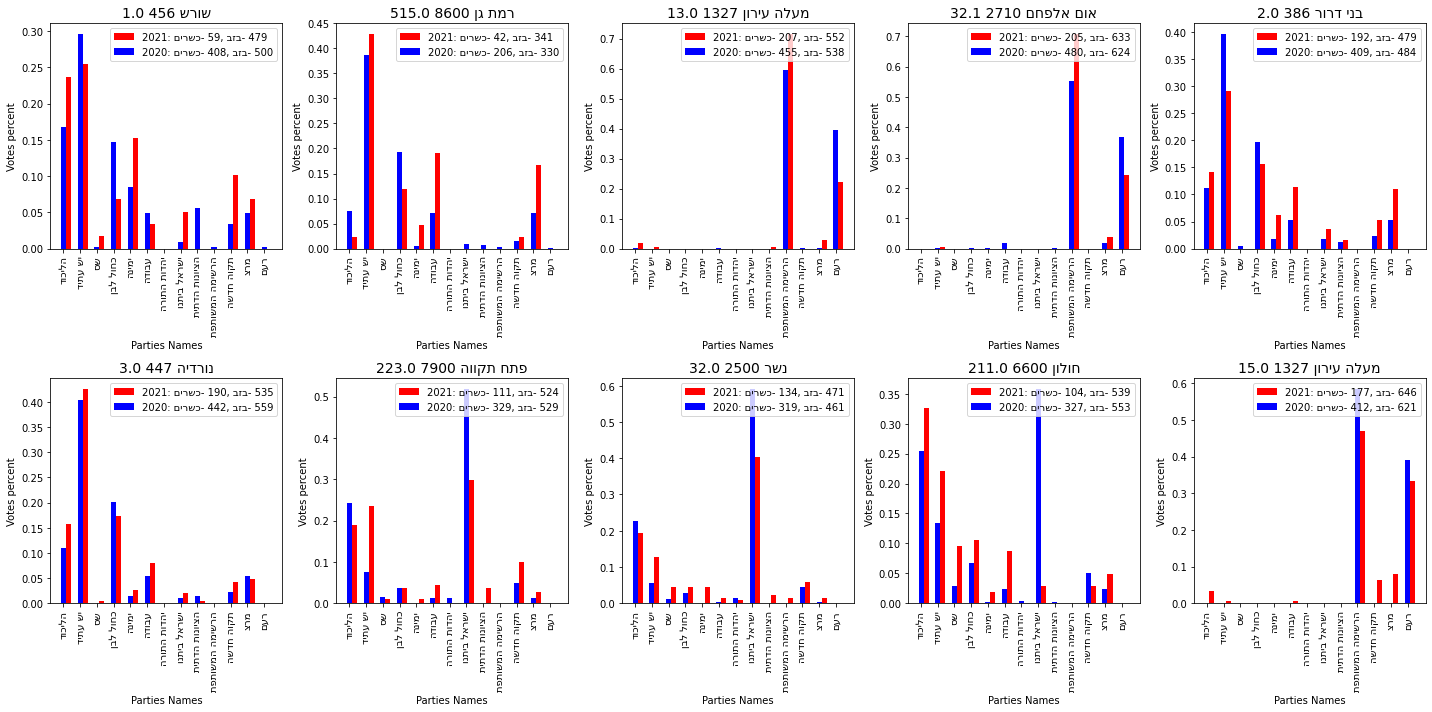

In [28]:
bar_plots(parties_2020, parties_2021, top_10_g.index, names)

In [29]:
centered_2021 = parties_2021[names] - parties_2021[names].mean(axis=0)
var_2021 = (1/(parties_2021.shape[0]-1)) * centered_2021.T @ centered_2021  # Compute variance-covariance matrix 
# Change order: 
ordered_names = [ 'הציונות הדתית' ,'שס', 'יהדות התורה','הליכוד', 'ימינה', 'תקוה חדשה','ישראל ביתנו', 'כחול לבן', 'יש עתיד','עבודה', 'מרצ' ,'רעם' ,'הרשימה המשותפת']
var_2021_ordered = var_2021[ordered_names].reindex(ordered_names)
var_2021_ordered

,הציונות הדתית,שס,יהדות התורה,הליכוד,ימינה,תקוה חדשה,ישראל ביתנו,כחול לבן,יש עתיד,עבודה,מרצ,רעם,הרשימה המשותפת
הציונות הדתית,0.008655,0.000851,0.000569,-0.000502,0.002645,-0.000533,-0.001333,-0.001569,-0.003371,-0.001759,-0.001420,-0.000965,-0.001144
שס,0.000851,0.006400,0.003589,0.003711,-0.000643,-0.000572,-0.000359,-0.001890,-0.004016,-0.002489,-0.001986,-0.001093,-0.001340
יהדות התורה,0.000569,0.003589,0.013167,-0.004795,-0.001002,-0.001004,-0.001137,-0.001666,-0.003245,-0.001629,-0.001170,-0.000605,-0.000786
הליכוד,-0.000502,0.003711,-0.004795,0.023509,0.000065,0.000778,0.002760,-0.002504,-0.005011,-0.005589,-0.004961,-0.003409,-0.004219
ימינה,0.002645,-0.000643,-0.001002,0.000065,0.003636,0.000324,-0.000820,-0.000130,-0.000551,-0.000428,-0.000640,-0.001089,-0.001336
תקוה חדשה,-0.000533,-0.000572,-0.001004,0.000778,0.000324,0.000721,0.000311,0.000442,0.001039,0.000137,-0.000108,-0.000732,-0.000865
ישראל ביתנו,-0.001333,-0.000359,-0.001137,0.002760,-0.000820,0.000311,0.005545,-0.000865,-0.000059,-0.001242,-0.001042,-0.001040,-0.000890
כחול לבן,-0.001569,-0.001890,-0.001666,-0.002504,-0.000130,0.000442,-0.000865,0.002817,0.003809,0.002409,0.001672,-0.001200,-0.001384
יש עתיד,-0.003371,-0.004016,-0.003245,-0.005011,-0.000551,0.001039,-0.000059,0.003809,0.008874,0.004122,0.003000,-0.002260,-0.002459
עבודה,-0.001759,-0.002489,-0.001629,-0.005589,-0.000428,0.000137,-0.001242,0.002409,0.004122,0.005133,0.003405,-0.001080,-0.001105


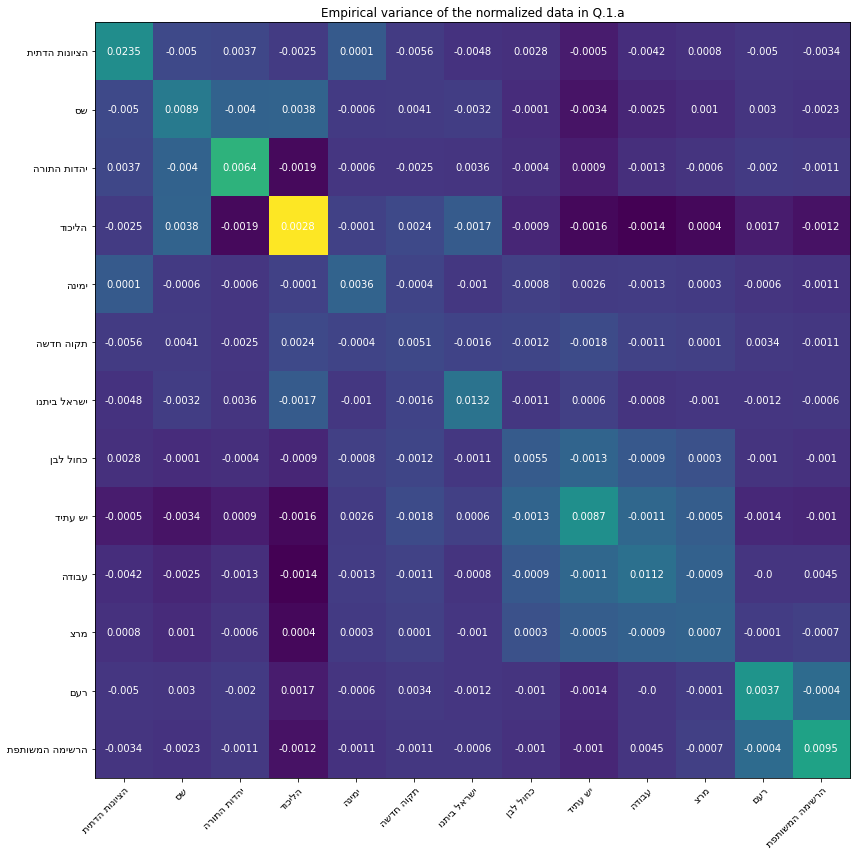

In [30]:
fig, ax = plt.subplots(figsize=(12,12))
im = ax.imshow(var_2021_ordered)
 

# Show all ticks and label them with the respective list entries
ordered_rev_names = [i[::-1] for i in ordered_names]
ax.set_xticks(np.arange(len(names)))
ax.set_yticks(np.arange(len(names)))
ax.set_xticklabels(ordered_rev_names)
ax.set_yticklabels(ordered_rev_names)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(names)):
    for j in range(len(names)):
        text = ax.text(j, i, round(var_2021.iloc[i, j],4),ha="center", va="center",color="w")

ax.set_title("Empirical variance of the normalized data in Q.1.a")
fig.tight_layout()
plt.show()

b. Ten ballots with the largest total squared difference between their voting shares for the 9 big parties in the two elections

In [31]:
# for 2020
diff_2020 = parties_2020_small[names].groupby('שם ישוב').apply(lambda x: diff_calc(x)).values
top_10_mahalanobis_2020 = pd.DataFrame(np.sqrt(diff_2020 @ np.linalg.inv(var_2021) @ diff_2020.T), index = parties_2020_small.index).sum(axis=1).nlargest(10)
top_10_mahalanobis_2020

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


קלפי   סמל ישוב  שם ישוב  
71.0   6900      כפר סבא      3753.285609
1.0    1296      כסראסמיע     3631.661807
9.0    1296      כסראסמיע     3494.487194
106.0  6900      כפר סבא      3445.377106
5.0    6900      כפר סבא      3427.369575
13.0   8400      רחובות       3396.375962
2.0    195       קדימהצורן    3366.299021
       6400      הרצליה       3298.792573
8.0    6400      הרצליה       3284.392951
6.0    6900      כפר סבא      3274.348504
dtype: float64

In [32]:
# for 2021
diff_2021 = parties_2021_small[names].groupby('שם ישוב').apply(lambda x: diff_calc(x)).values
top_10_mahalanobis_2021 = pd.DataFrame(np.sqrt(diff_2021 @ np.linalg.inv(var_2021) @ diff_2021.T), index = parties_2021_small.index).sum(axis=1).nlargest(10)
top_10_mahalanobis_2021

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


קלפי  סמל ישוב  שם ישוב  
90.0  2200      דימונה       2997.055910
2.0   4501      עגר          2196.642798
1.0   2630      קרית גת      2116.365703
52.0  1061      נוף הגליל    1977.531489
20.0  6500      חדרה         1919.554732
50.0  2640      ראש העין     1880.835214
3.0   4501      עגר          1872.824930
32.0  2640      ראש העין     1862.731029
1.0   1296      כסראסמיע     1835.254208
6.5   1304      שוהם         1822.593450
dtype: float64

c. Ten ballots with the largest total squared difference between their voting shares for the 9 big parties in the two elections


In [33]:
diff_c = (parties_2020[names]-parties_2021[names]).values
top_10_mahalanobis_c = (pd.DataFrame(np.sqrt(diff_c @ np.linalg.inv(var_2021) @ diff_c.T), index = parties_2021.index)).sum(axis=1).nlargest(10)
top_10_mahalanobis_c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


קלפי  סמל ישוב  שם ישוב  
1.0   648       מצר          48602.911398
      399       בארי         48402.974935
      1209      חרשים        47983.171755
      1156      סמר          47613.143924
      1172      תובל         47502.120573
      465       צובה         47472.718275
      130       משמר העמק    47016.455735
2.0   130       משמר העמק    46711.744271
1.0   1254      נטף          46526.129468
      402       ניר יצחק     46502.931861
dtype: float64

Redo b. Differences are more spread across multiple parties compared to using L2 distance where there was a big change in one or two parties

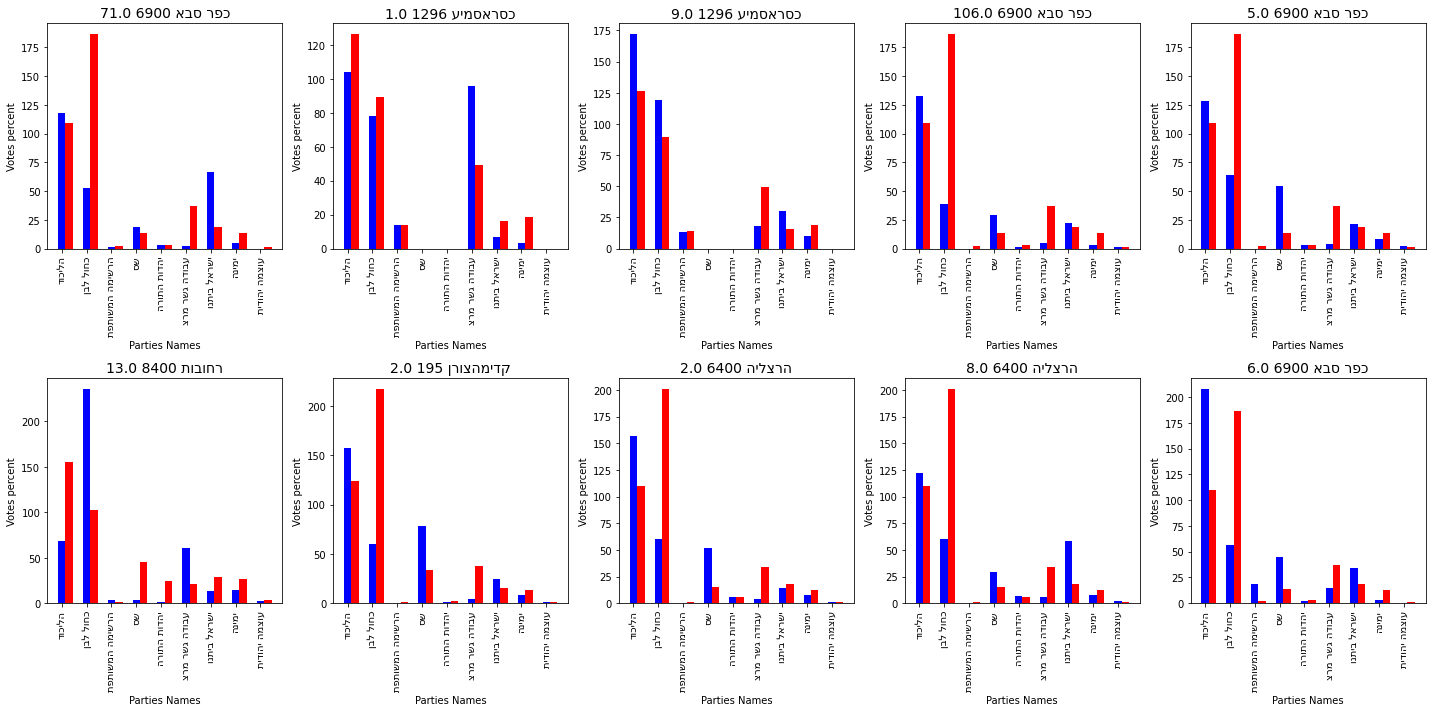

In [44]:
bar_plots(ballot_2020, parties_2020, top_10_mahalanobis_2020.index, names_2020, True, False)

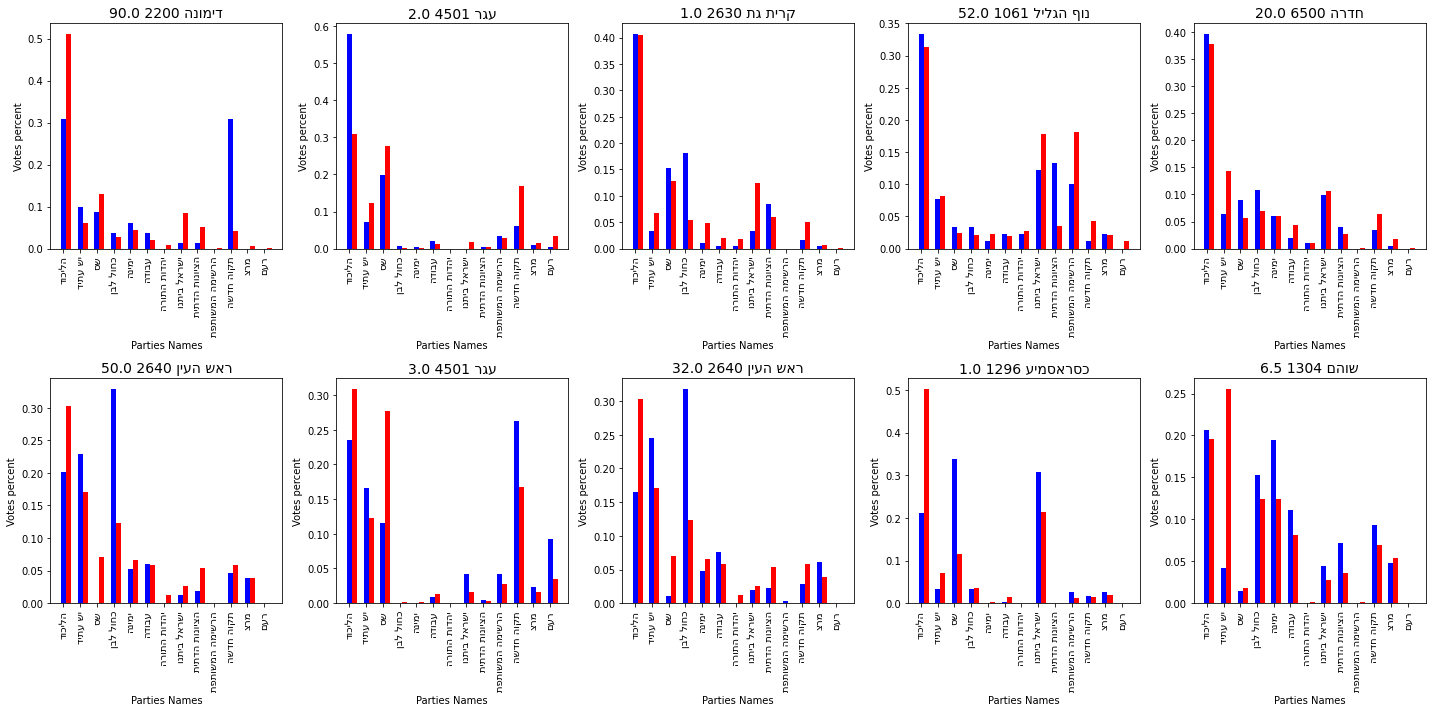

In [45]:
bar_plots(parties_2021, parties_2021, top_10_mahalanobis_2021.index, names, True, True)

Redo c. Differences are more spread across multiple parties compared to using L2 distance where there was a big change in one or two parties

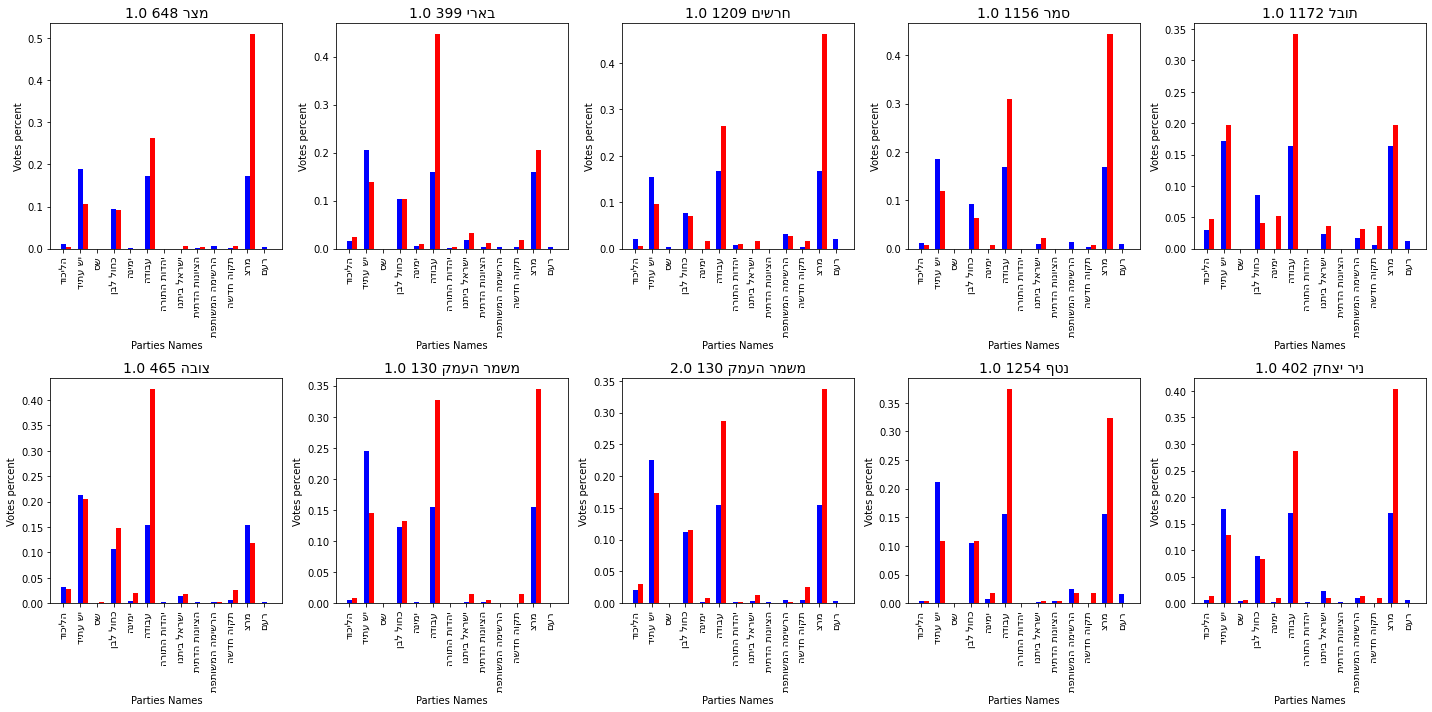

In [46]:
bar_plots(parties_2020, parties_2021, top_10_mahalanobis_c.index, names)